# Managing Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import datetime

# Libraries for Network creation
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MSELoss
from torch.nn import MaxPool2d, Module, BatchNorm2d, Flatten, ConvTranspose2d
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

import collections
from collections import OrderedDict
from collections import Counter

# Libraries of models
import torchvision
from torchvision import transforms
from torchvision import datasets as dataset
from torchvision import utils as vutils

# make sure you use the GPU (btw check your runtime is a GPU in colab)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Prepare Data

## Ready dataset import variables

In [22]:
train = 'input/train/train'
test = 'input/test/test'
destination = test + '/unlabeled/'

if not os.path.exists(destination):
    os.mkdir(destination)

# Move test data to folder
file_names = os.listdir(test)
for file_name in file_names:
    if os.path.exists(os.path.join(test, file_name)):
        shutil.move(os.path.join(test, file_name), destination)

## Create Dataset

In [23]:
class ImageFolderWithPaths(dataset.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

train_data = ImageFolderWithPaths(root=train,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                           ]))
print('Full train data size', train_data.__len__())

test_data = ImageFolderWithPaths(root=test,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                           ]))
print('Test data size', test_data.__len__())

Full train data size 1700
Test data size 3200


## Distribution of images in Train dataset

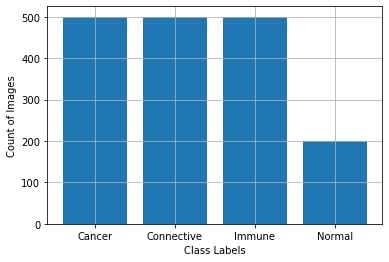

In [21]:
class_to_index = train_data.class_to_idx

labels_count = {}
for key, value in class_to_index.items():
  labels_count[key] = dict(Counter(train_data.targets))[value]

plt.bar(list(labels_count.keys()), list(labels_count.values()))
plt.xlabel('Class Labels')
plt.ylabel('Count of Images')
plt.grid(True)
plt.show()

## Create Data Loaders

In [7]:
train_dl = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

# Plot some training images
real_batch = next(iter(train_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))  

test_dl = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=2)

# Plot some test images
real_batch = next(iter(test_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))  

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mojojojo/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mojojojo/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ImageFolderWithPaths' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mojojojo/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mojojojo/opt/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ImageFolderWithPaths' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 4453) exited unexpectedly

# Prepare Simple Convolutional Network

## Creating the network model

In [7]:
model = Sequential(OrderedDict([ # -> 3, 32, 32
          ('conv1', Conv2d(3,16,3,padding=1)),  
          ('normalise1', BatchNorm2d(16)),
          ('relu1', ReLU()),
          ('conv2', Conv2d(16,32,3,padding=1)), 
          ('relu2', ReLU()),
          ('conv3', Conv2d(32,64,3,padding=1)), 
          ('relu3', ReLU()),
          ('maxpool1', MaxPool2d(kernel_size=2)),
          ('flatten', Flatten()),
          ('lin1', Linear(64*16*16, 1024)),
          ('relu4', ReLU()),
          ('lin2', Linear(1024, 4))
        ]))

## Methods to train and test model

In [8]:
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels, image_name in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))


def test_loop(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, image_name in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



## Training and testing the model on train data

In [9]:
# optimizer = Adam(model.parameters())
optimizer = SGD(model.parameters(), lr=0.01)

loss_fn = CrossEntropyLoss(weight=torch.FloatTensor([0.7, 0.7, 0.85, 1.00]))
model = model.to(device)

n_epochs = 10 

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    loss_fn = loss_fn,
    train_loader = train_dl
)

test_loop(model = model, test_loader = train_dl)

2022-03-25 22:39:41.088073 Epoch 1, Training loss 18.144352436065674
2022-03-25 22:39:52.122772 Epoch 2, Training loss 15.920716881752014
2022-03-25 22:40:04.810365 Epoch 3, Training loss 12.934784710407257
2022-03-25 22:40:15.820385 Epoch 4, Training loss 10.18836522102356
2022-03-25 22:40:26.695393 Epoch 5, Training loss 8.62924736738205
2022-03-25 22:40:42.230560 Epoch 6, Training loss 7.744423598051071
2022-03-25 22:40:53.308261 Epoch 7, Training loss 7.142036944627762
2022-03-25 22:41:05.353584 Epoch 8, Training loss 6.551529258489609
2022-03-25 22:41:17.200136 Epoch 9, Training loss 6.2242125272750854
2022-03-25 22:41:28.303807 Epoch 10, Training loss 5.805073082447052

Test set: Average loss: -2.9811, Accuracy: 1450/1700 (85%)



## Predict class for test data

In [10]:
def extract_image_name(filenames):
  # Sample filename - 'kaggle/input/deep-learning-for-msc-coursework-2022/test/test/unlabeled/tile5001.png'
  names = []
  for name in filenames:
    names.append(name.split('/')[-1])
  return names

def transform_to_class(predicted):
  labels = []
  for pred in predicted:
    val = pred[0]
    for key, value in class_to_index.items():
      if val == value:
        labels.append(key)
  return labels

def predict(model, test_loader):
  model.eval()    
  images, preds = [], []
  with torch.no_grad():
    for data, target, image_name in test_loader:
      data = data.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      preds = preds + transform_to_class(pred.detach().numpy())
      images = images + extract_image_name(image_name)

  return preds, images

preds, images = predict(model, test_dl)

## Save results to test.csv

In [11]:
print('Cancer', preds.count('Cancer'))
print('Immune', preds.count('Immune'))
print('Connective', preds.count('Connective'))
print('Normal', preds.count('Normal'))

results_df = pd.DataFrame({'Id': images, 'Type': preds})
display(results_df)
results_df.to_csv('simple_test.csv', index=False)

Cancer 1032
Immune 676
Connective 584
Normal 908


,Id,Type
0,tile6364.png,Normal
1,tile5040.png,Connective
2,tile5681.png,Connective
3,tile5071.png,Cancer
4,tile6218.png,Normal
...,...,...
3195,tile7300.png,Cancer
3196,tile5017.png,Cancer
3197,tile7122.png,Cancer
3198,tile5165.png,Cancer


# Prepare Autoencoder

## Creating the encoder, decoder and autoencoder class definitions

In [12]:
class Encoder(Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.cnn_encoder = Sequential(OrderedDict([
        ('conv1', Conv2d(3,32,3,padding=1)), 
        ('relu1', ReLU()),
        ('conv2', Conv2d(32,64,3,padding=1)), 
        ('relu2', ReLU()),
        ('maxpool1',MaxPool2d(2))
      ]))
        
  def forward(self, x):
    return self.cnn_encoder(x)

class Decoder(Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.cnn_decoder = Sequential(OrderedDict([
      ('transpose1', ConvTranspose2d(64,32,3,stride=2,output_padding=1)),
      ('relu1', ReLU()),
      ('transpose2', ConvTranspose2d(32,3,3,padding=2)),
      ('relu2', ReLU()),
    ]))

  def forward(self, x):
    x = self.cnn_decoder(x)
    x = torch.sigmoid(x)
    return x

class Autoencoder(Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    y = self.encoder(x)
    y = self.decoder(y)
    return y

## Method to train autoencoder

In [13]:
epoch_print_gap = 1

def train_autoencoder(model, train_loader, n_epochs, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.encoder.train()
    model.decoder.train()

    for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels, image_name in train_loader:
        encoded_output = model.encoder(imgs)
        decoded_output = model.decoder(encoded_output)
        
        loss = loss_fn(decoded_output, imgs)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
            
      if epoch == 1 or epoch % epoch_print_gap == 0:
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch, float(loss_train)))


## Training autoencoder on unlabelled dataset

In [14]:
autoencoder = Autoencoder().to(device)

loss_fn = MSELoss()

optimizer = SGD(autoencoder.parameters(), lr=0.01)

n_epochs = 20

train_autoencoder(autoencoder, test_dl, n_epochs, loss_fn, optimizer)

torch.save(autoencoder.encoder.state_dict(), 'AutoEncoder_encoder_state.pth')

2022-03-25 22:42:02.314778 Epoch 1, Training loss 29.34079098701477
2022-03-25 22:42:19.816240 Epoch 2, Training loss 26.141397714614868
2022-03-25 22:42:35.769346 Epoch 3, Training loss 22.842299818992615
2022-03-25 22:42:53.847684 Epoch 4, Training loss 20.792163848876953
2022-03-25 22:43:09.491278 Epoch 5, Training loss 19.12102872133255
2022-03-25 22:43:27.308331 Epoch 6, Training loss 18.768859803676605
2022-03-25 22:43:43.119526 Epoch 7, Training loss 18.629883289337158
2022-03-25 22:44:00.818283 Epoch 8, Training loss 18.543194353580475
2022-03-25 22:44:16.518595 Epoch 9, Training loss 18.476490199565887
2022-03-25 22:44:35.277718 Epoch 10, Training loss 18.418786644935608
2022-03-25 22:44:59.715566 Epoch 11, Training loss 18.365592181682587
2022-03-25 22:45:15.671595 Epoch 12, Training loss 18.314928889274597
2022-03-25 22:45:33.580503 Epoch 13, Training loss 18.266565561294556
2022-03-25 22:45:49.414373 Epoch 14, Training loss 18.22133082151413
2022-03-25 22:46:06.882534 Epoch

# Prepare Encoder based Convolutional Network

## Create the network model

In [15]:
encode_model = Sequential(OrderedDict([
                 ('conv1', Conv2d(64,64,3,padding=1)),
                 ('relu1', ReLU()),
                 ('conv2', Conv2d(64,128,3,padding=1)),
                 ('relu2', ReLU()),
                 ('conv3', Conv2d(128,256,3,padding=1)),
                 ('relu3', ReLU()),
                 ('flatten', Flatten()),
                 ('lin1', Linear(256*16*16, 2048)),
                 ('relu4', ReLU()),
                 ('lin2', Linear(2048,4))
              ]))

encoder = Encoder()
encoder.load_state_dict(torch.load('AutoEncoder_encoder_state.pth'))

<All keys matched successfully>

## Method to train and test encoder CNN model

In [16]:
epoch_print_gap = 1

def train_encoder_model(n_epochs, optimizer, model, encoder, loss_fn, train_loader):
    model.train() 
    encoder.eval()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels, image_name in train_loader:
            encoded_output = encoder(imgs)
            outputs = model(encoded_output)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))


def test_encoder_model(model, encoder, test_loader):
    model.eval()
    encoder.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, image_name in test_loader:
            encoded_output = encoder(data)
            outputs = model(encoded_output)
            test_loss += F.nll_loss(outputs, target, reduction='sum').item()  # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## Training and testing the encoded CNN model

In [ ]:
optimizer = SGD(encode_model.parameters(), lr=0.01)

loss_fn = CrossEntropyLoss(weight=torch.FloatTensor([0.7, 0.7, 0.85, 1.00]))

n_epochs = 20 

# train the CNN
train_encoder_model(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = encode_model, 
    encoder = encoder,
    loss_fn = loss_fn,
    train_loader = train_dl
)

test_encoder_model(model=encode_model, encoder=encoder, test_loader=train_dl)

2022-03-25 22:48:31.914636 Epoch 1, Training loss 18.47675085067749
2022-03-25 22:49:25.937062 Epoch 2, Training loss 16.460161566734314
2022-03-25 22:50:15.336560 Epoch 3, Training loss 14.730190753936768
2022-03-25 22:51:08.721540 Epoch 4, Training loss 14.165429055690765
2022-03-25 22:52:00.078304 Epoch 5, Training loss 12.870494902133942
2022-03-25 22:52:51.236199 Epoch 6, Training loss 11.659909546375275
2022-03-25 22:53:42.379447 Epoch 7, Training loss 11.141396164894104
2022-03-25 22:54:32.039235 Epoch 8, Training loss 11.098358929157257
2022-03-25 22:55:25.024235 Epoch 9, Training loss 11.60904175043106
2022-03-25 22:56:24.004799 Epoch 10, Training loss 10.745695650577545
2022-03-25 22:57:15.679994 Epoch 11, Training loss 11.228126645088196
2022-03-25 22:58:05.563867 Epoch 12, Training loss 11.096832036972046
2022-03-25 22:58:55.018250 Epoch 13, Training loss 9.879035830497742
2022-03-25 22:59:44.938710 Epoch 14, Training loss 11.581725895404816
2022-03-25 23:00:34.331510 Epoch

## Predict class for test data

In [ ]:
def predict_encoded_model(model, encoder, test_loader):
  model.eval() 
  encoder.eval()   
  images, preds = [], []
  with torch.no_grad():
    for data, target, image_name in test_loader:
      encoded_output = encoder(data)
      output = model(encoded_output)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      preds = preds + transform_to_class(pred.detach().numpy())
      images = images + extract_image_name(image_name)

  return preds, images

preds, images = predict_encoded_model(encode_model, encoder, test_dl)

## Save results to test.csv

In [ ]:
print('Cancer', preds.count('Cancer'))
print('Immune', preds.count('Immune'))
print('Connective', preds.count('Connective'))
print('Normal', preds.count('Normal'))

results_df = pd.DataFrame({'Id': images, 'Type': preds})
display(results_df)
results_df.to_csv('encoder_test.csv', index=False)